## ECoG Movement decoding example 

This example notebook read openly accessible data from the publication *Electrocorticography is superior to subthalamic local field potentials for movement decoding in Parkinson’s disease* ([Merk et al. 2022](https://elifesciences.org/articles/75126)). The dataset is available [here](https://doi.org/10.7910/DVN/IO2FLM).

For simplicity one example subject is automatically shipped within this repo at the *examples/data* folder, stored in [iEEG BIDS](https://www.nature.com/articles/s41597-019-0105-7) format.


In [22]:
import py_neuromodulation as nm
import xgboost
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
    nm_settings,
    nm_stats
)
from sklearn import metrics, model_selection
import json
import matplotlib.pyplot as plt
import numpy as np
import os

Let's read the example using [mne_bids](https://mne.tools/mne-bids/stable/index.html). The resulting raw object in of type [mne.RawArray](https://mne.tools/stable/generated/mne.io.RawArray.html). We can use the properties such as sampling frequency, channel names, channel types all from the mne array and create the *nm_channels* dataframe:

In [2]:
RUN_NAME, PATH_RUN, PATH_BIDS, PATH_OUT, datatype = nm_IO.get_paths_example_data()

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

nm_channels = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference="default",
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog", "dbs", "seeg"),
    target_keywords="MOV_RIGHT_CLEAN",
)

nm_channels

Extracting parameters from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
Reading channel info from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_channels.tsv.
Reading electrode coords from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_space-mni_electrodes.tsv.


,name,rereference,used,target,type,status,new_name
0,LFP_RIGHT_0,LFP_RIGHT_2,1,0,seeg,good,LFP_RIGHT_0-LFP_RIGHT_2
1,LFP_RIGHT_1,LFP_RIGHT_0,1,0,seeg,good,LFP_RIGHT_1-LFP_RIGHT_0
2,LFP_RIGHT_2,LFP_RIGHT_1,1,0,seeg,good,LFP_RIGHT_2-LFP_RIGHT_1
3,ECOG_RIGHT_0,average,1,0,ecog,good,ECOG_RIGHT_0-avgref
4,ECOG_RIGHT_1,average,1,0,ecog,good,ECOG_RIGHT_1-avgref
5,ECOG_RIGHT_2,average,1,0,ecog,good,ECOG_RIGHT_2-avgref
6,ECOG_RIGHT_3,average,1,0,ecog,good,ECOG_RIGHT_3-avgref
7,ECOG_RIGHT_4,average,1,0,ecog,good,ECOG_RIGHT_4-avgref
8,ECOG_RIGHT_5,average,1,0,ecog,good,ECOG_RIGHT_5-avgref
9,MOV_RIGHT,None,0,0,misc,good,MOV_RIGHT


This example contains the force grip movement traces, we'll use the *MOV_RIGHT_CLEAN* channel as a decoding target channel. Let's check some of the raw feature and time series traces:

(0.0, 20.0)

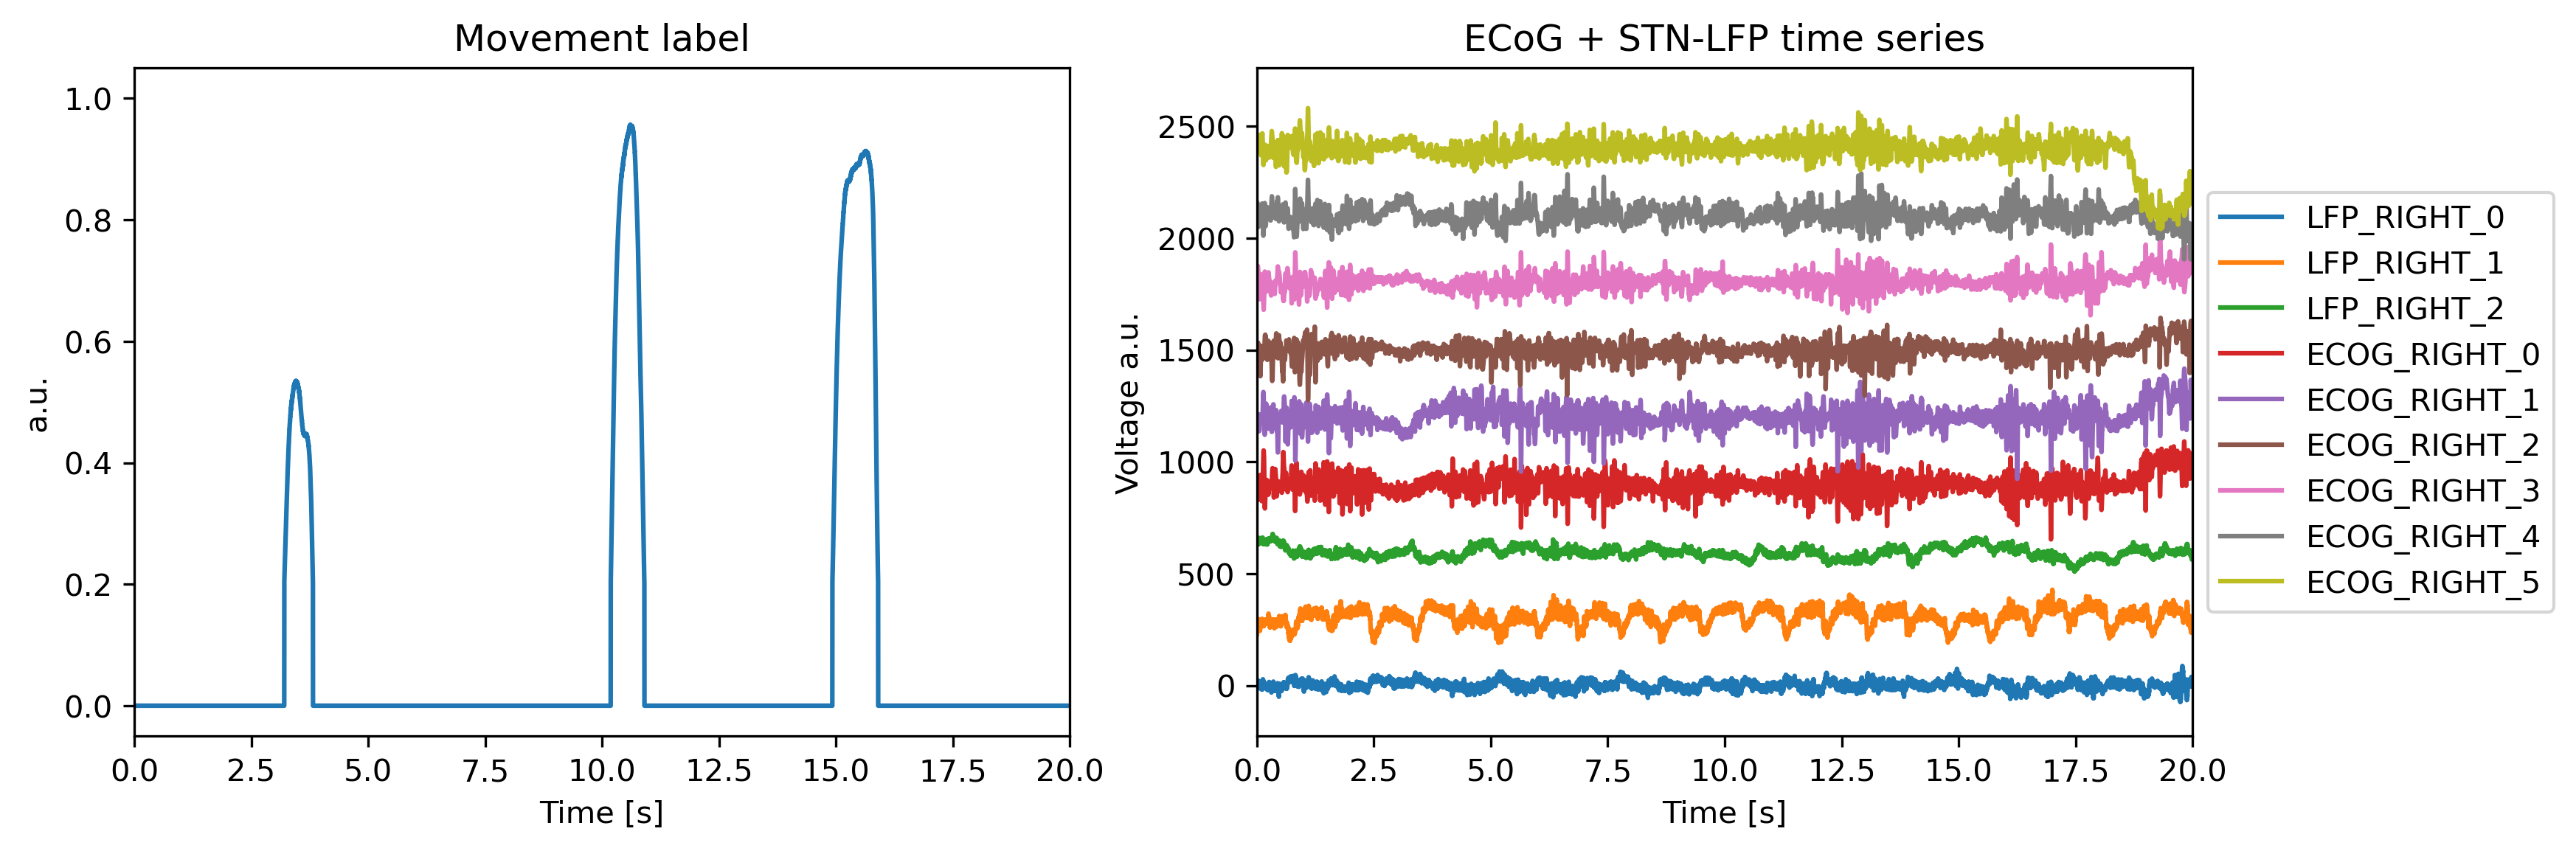

In [3]:
plt.figure(figsize=(12, 4), dpi=300)
plt.subplot(121)
plt.plot(raw.times, data[-2, :])
plt.xlabel("Time [s]")
plt.ylabel("a.u.")
plt.title("Movement label")
plt.xlim(0, 20)

plt.subplot(122)
for idx, ch_name in enumerate(nm_channels.query("used == 1").name):
    plt.plot(raw.times, data[idx, :] + idx*300, label=ch_name)
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.title("ECoG + STN-LFP time series")
plt.xlabel("Time [s]")
plt.ylabel("Voltage a.u.")
plt.xlim(0, 20)

In [4]:
settings = nm_settings.get_default_settings()
settings = nm_settings.set_settings_fast_compute(settings)

In [18]:
stream = nm.Stream(
    sfreq=sfreq,
    nm_channels=nm_channels,
    settings=settings,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
    verbose=False,
)


No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)



In [ ]:
stream.run(
    data=data,
    out_path_root=PATH_OUT,
    folder_name=RUN_NAME,
)

In [7]:
# init analyzer
feature_reader = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

In [8]:
ch_used = feature_reader.nm_channels.query(
    '(type=="ecog") and (used == 1)'
).iloc[0]["name"]

In [10]:
feature_reader.settings

{'sampling_rate_features_hz': 10,
 'segment_length_features_ms': 1000,
 'preprocessing': ['notch_filter', 're_referencing'],
 'documentation_preprocessing_options': ['raw_resampling',
  'notch_filter',
  're_referencing',
  'raw_normalization'],
 'features': {'raw_hjorth': False,
  'return_raw': False,
  'bandpass_filter': False,
  'stft': False,
  'fft': True,
  'sharpwave_analysis': False,
  'coherence': False,
  'fooof': False,
  'nolds': False,
  'bursts': False,
  'linelength': False,
  'mne_connectivity': False},
 'postprocessing': {'feature_normalization': True,
  'project_cortex': False,
  'project_subcortex': False},
 'raw_resampling_settings': {'resample_freq_hz': 1000},
 'documentation_normalization_options': ['mean',
  'median',
  'zscore',
  'zscore-median',
  'quantile',
  'power',
  'robust',
  'minmax'],
 'raw_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'feature_normalization_settings': {'normalization_time_s'

Feature epoch average figure saved to: C:\code\py_neuromodulation\examples\data\derivatives\sub-000_ses-right_task-force_run-3\MOV_aligned_features_ch_ECOG_RIGHT_0_fft.png


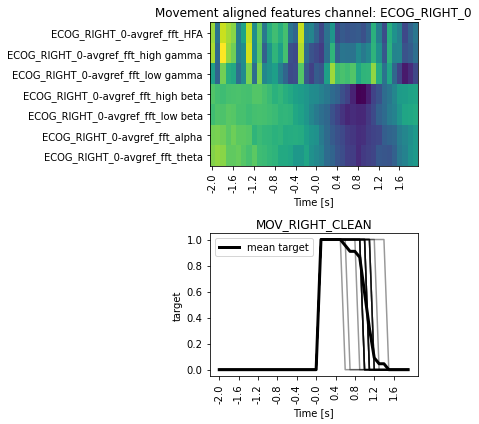

In [9]:
feature_reader.plot_target_averaged_channel(
    ch=ch_used,
    list_feature_keywords=["fft"],
    epoch_len=4,
    threshold=0.5,
)

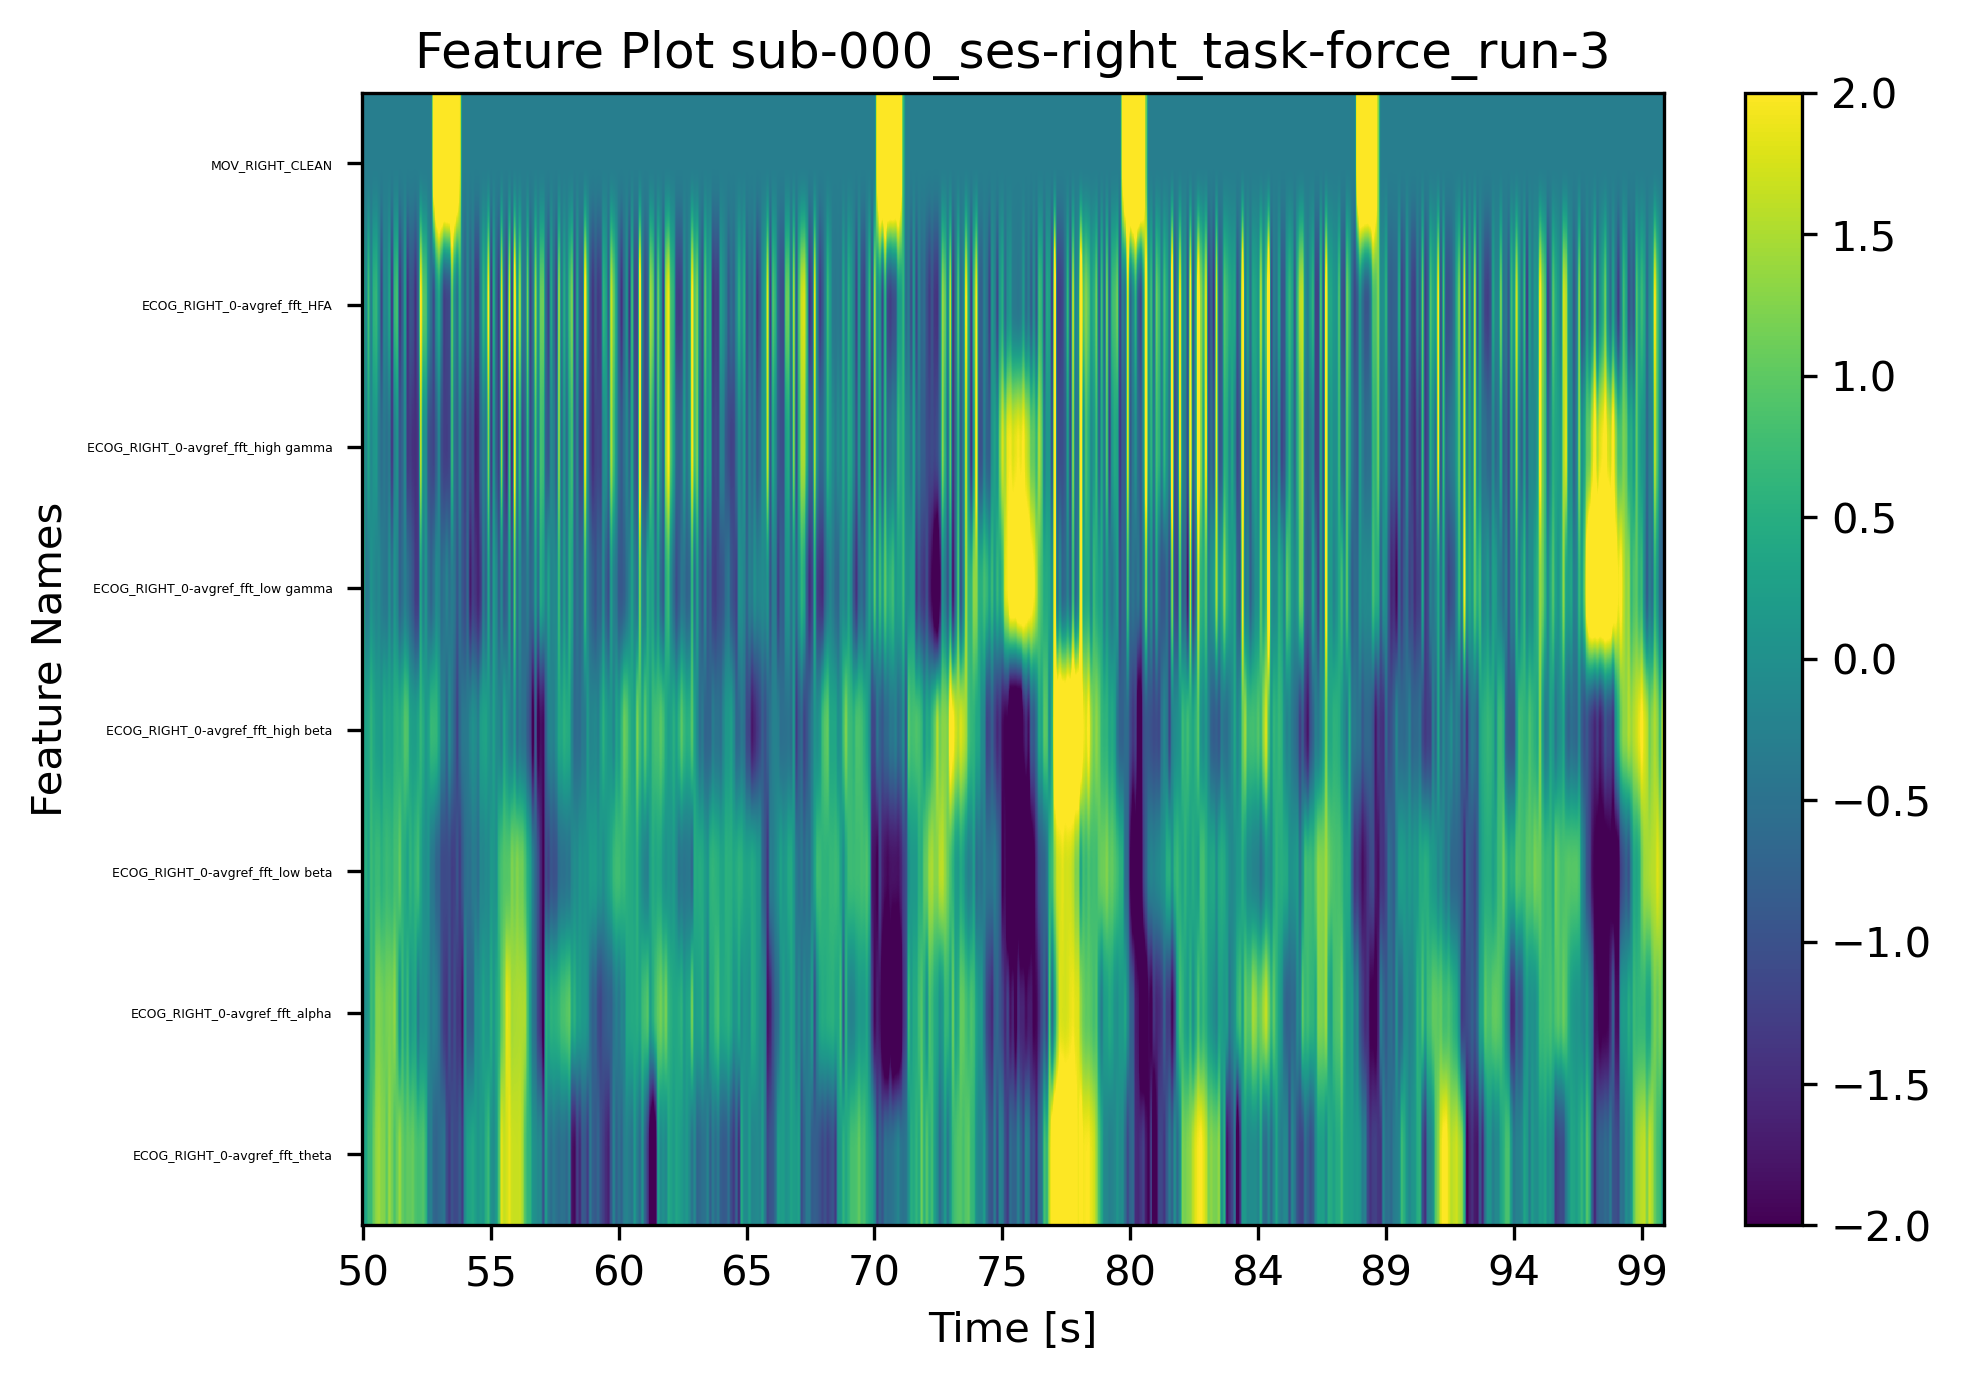

In [13]:
feature_reader.plot_all_features(
    ytick_labelsize=3,
    clim_low=-2,
    clim_high=2,
    ch_used="ECOG_RIGHT_0",
    time_limit_low_s=50,
    time_limit_high_s=100,
    normalize=True,
    save=True,
)

## Decoding

The main focus of the py_neuromodulation pipeline is the feature estimation. Nevertheless, the user can also use the pipeline for Machine Learning decoding. It can be used for regression and classification problems, and also for unsupervised methods, such as PCA and CCA.

Here we show an example using the XGBOOST Classifier. The labels used come from the target, in this case, the "MOV_LEFT_CLEAN".

The performance results are saved and plotted below. Again the figure is saved as a .png in the /py_neuromodulation/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/ directory.

In [ ]:
model = xgboost.XGBRegressor()

feature_reader.decoder = nm_decode.Decoder(
    features=feature_reader.feature_arr,
    label=feature_reader.label,
    label_name=feature_reader.label_name,
    used_chs=feature_reader.used_chs,
    model=model,
    eval_method=metrics.r2_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
    get_movement_detection_rate=False,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    use_nested_cv=False,
    sfreq=feature_reader.settings["sampling_rate_features_hz"],
)

performances = feature_reader.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per = feature_reader.get_dataframe_performances(performances)

nm_plots.plot_df_subjects(
    df_per, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT, RUN_NAME, RUN_NAME + "_decoding_performance.png")
)